In [28]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv("data/cf_train_no_noise.csv")
df_noise = pd.read_csv("data/cf_train.csv")

In [30]:
def encode(value, encoding):
    for key, val in encoding.items():
        if value == key:
            return val

class_values_era = list(df.era.unique())
class_values_era.sort()
class_values_target = list(df.target_10_val.unique())
class_values_target.sort()
era_encoding = {val: i for i, val in enumerate(class_values_era)}
target_encoding = {val: i for i, val in enumerate(class_values_target)}
df["era"] = df["era"].apply(encode, args=(era_encoding,))
df["target_5_val"] = df["target_5_val"].apply(encode, args=(target_encoding,))
df["target_10_val"] = df["target_10_val"].apply(encode, args=(target_encoding,))

df_noise["era"] = df_noise["era"].apply(encode, args=(era_encoding,))
df_noise["target_5_val"] = df_noise["target_5_val"].apply(encode, args=(target_encoding,))
df_noise["target_10_val"] = df_noise["target_10_val"].apply(encode, args=(target_encoding,))

dataset = df
target_column = "target_10_val"
output_classes = 5
shuffle = True

In [31]:
dataset

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,era,target_10_val,target_5_val,sigma,day_no
0,0.50,0.50,0.50,0.50,0.0,0.25,0.25,0.50,0.25,1.00,...,0.50,0.50,0.50,75,540,6,1,0,_0_0_,0
1,0.50,0.50,0.50,0.50,0.0,0.25,0.25,0.50,0.50,0.75,...,0.50,0.50,0.50,76,540,6,1,0,_0_0_,0
2,0.50,0.50,0.50,0.50,0.0,0.50,0.25,0.50,0.50,0.75,...,0.25,0.25,0.25,77,540,6,1,1,_0_0_,0
3,0.50,0.50,0.25,0.25,0.0,0.50,0.25,0.50,0.50,0.75,...,0.25,0.25,0.25,78,540,6,1,1,_0_0_,0
4,0.25,0.25,0.25,0.25,0.0,0.50,0.25,0.50,0.50,0.75,...,0.50,0.25,0.25,79,540,6,3,1,_0_0_,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62395,1.00,1.00,1.00,1.00,0.0,1.00,1.00,1.00,0.50,0.75,...,0.00,0.00,0.00,135,537,5,0,0,_0_0_,959
62396,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.75,0.50,0.75,...,0.00,0.00,0.00,136,537,5,0,0,_0_0_,959
62397,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.75,0.50,0.75,...,0.00,0.00,0.00,137,537,5,0,0,_0_0_,959
62398,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.75,0.25,1.00,...,0.00,0.00,0.00,138,537,5,0,0,_0_0_,959


In [32]:
# remove target_5_val, sigma from the dataset
new_dataset = dataset.drop(columns=["target_5_val", "sigma"])
era = new_dataset.pop("era")
target = new_dataset.pop(target_column)
new_dataset[target_column] = target
new_dataset["era"] = era
new_dataset

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,day_no,target_10_val,era
0,0.50,0.50,0.50,0.50,0.0,0.25,0.25,0.50,0.25,1.00,...,0.50,0.25,0.50,0.50,0.50,75,540,0,1,6
1,0.50,0.50,0.50,0.50,0.0,0.25,0.25,0.50,0.50,0.75,...,0.50,0.00,0.50,0.50,0.50,76,540,0,1,6
2,0.50,0.50,0.50,0.50,0.0,0.50,0.25,0.50,0.50,0.75,...,0.50,0.00,0.25,0.25,0.25,77,540,0,1,6
3,0.50,0.50,0.25,0.25,0.0,0.50,0.25,0.50,0.50,0.75,...,0.25,0.00,0.25,0.25,0.25,78,540,0,1,6
4,0.25,0.25,0.25,0.25,0.0,0.50,0.25,0.50,0.50,0.75,...,0.25,0.00,0.50,0.25,0.25,79,540,0,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62395,1.00,1.00,1.00,1.00,0.0,1.00,1.00,1.00,0.50,0.75,...,1.00,1.00,0.00,0.00,0.00,135,537,959,0,5
62396,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.75,0.50,0.75,...,1.00,1.00,0.00,0.00,0.00,136,537,959,0,5
62397,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.75,0.50,0.75,...,1.00,1.00,0.00,0.00,0.00,137,537,959,0,5
62398,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.75,0.25,1.00,...,1.00,1.00,0.00,0.00,0.00,138,537,959,0,5


In [33]:
class CustomDataset(Dataset):
    def __init__(self, X,y):
        self.X =X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [34]:
train_dataset = CustomDataset(new_dataset.drop(columns=[target_column,'era','row_num','day','day_no']).values, new_dataset[target_column].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=shuffle)

In [35]:
# load test_data
df_test = pd.read_csv("data/cf_test_no_noise.csv")
df_test_noise = pd.read_csv("data/cf_test.csv")

df_test["era"] = df_test["era"].apply(encode, args=(era_encoding,))
df_test["target_5_val"] = df_test["target_5_val"].apply(encode, args=(target_encoding,))
df_test["target_10_val"] = df_test["target_10_val"].apply(encode, args=(target_encoding,))
df_test_noise["era"] = df_test_noise["era"].apply(encode, args=(era_encoding,))
df_test_noise["target_5_val"] = df_test_noise["target_5_val"].apply(encode, args=(target_encoding,))
df_test_noise["target_10_val"] = df_test_noise["target_10_val"].apply(encode, args=(target_encoding,))

test_set = df_test
target_column = "target_10_val"
output_classes = 5


In [36]:
new_test_dataset= test_set.drop(columns=["target_5_val", "sigma"])
era = new_test_dataset.pop("era")
target = new_test_dataset.pop(target_column)
new_test_dataset[target_column] = target
new_test_dataset["era"] = era
new_test_dataset


,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,day_no,target_10_val,era
0,0.50,0.50,0.50,0.50,0.0,0.75,0.75,0.25,0.25,0.0,...,0.50,1.00,0.50,0.75,0.50,75,555,0,4,None
1,0.50,0.50,0.50,0.50,0.0,0.50,0.75,0.25,0.25,0.0,...,0.75,1.00,0.75,0.75,0.75,76,555,0,4,None
2,0.50,0.50,0.50,0.50,0.0,0.50,0.75,0.50,0.25,0.0,...,0.75,0.50,0.75,0.75,0.75,77,555,0,4,None
3,0.50,0.50,0.50,0.75,0.0,0.50,0.75,0.50,0.25,0.0,...,0.75,0.50,0.75,0.75,0.75,78,555,0,4,None
4,0.75,0.75,0.75,0.75,0.0,0.50,0.75,0.50,0.25,0.0,...,0.75,0.25,0.50,0.75,0.75,79,555,0,4,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62395,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.25,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,135,550,959,0,None
62396,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.25,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,136,550,959,0,None
62397,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.00,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,137,550,959,0,None
62398,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.00,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,138,550,959,0,None


In [37]:
test_dataset = CustomDataset(new_test_dataset.drop(columns=[target_column,'era','row_num','day','day_no']).values, new_test_dataset[target_column].values)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [38]:
next(iter(test_loader))

[tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.0000, 0.7500, 0.7500, 0.2500, 0.2500,
          0.0000, 0.7500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.5000,
          0.0000, 0.5000, 1.0000, 0.5000, 0.7500, 0.5000]], dtype=torch.float64),
 tensor([4])]

In [39]:
# define the model
class TTA(nn.Module):
    def __init__(self, input_size, classification_output_size,auxiliary_output_size):
        super(TTA, self).__init__()
        self.NAL_layers = nn.Sequential(
            nn.Linear(classification_output_size, 1),            
        )

        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.ReLU()
        )
        self.prediction_branch = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, classification_output_size)
        )
        self.auxiliary_branch = nn.Sequential(
            nn.Linear(64, auxiliary_output_size),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, auxiliary_output_size)
        )
    def forward(self, x):
        x = self.shared_layers(x)
        # get output from second to last layer in prediction branch
        nal_in = self.prediction_branch(x)
        nal_out = torch.sigmoid(self.NAL_layers(nal_in)).to(torch.float64)

        return (self.prediction_branch(x)), self.auxiliary_branch(x), nal_out

class NoiseAttentionLoss(nn.Module):
    def __init__(self, lambda_=50):
        super(NoiseAttentionLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, logits, y, tau):
        y = F.one_hot(y, output_classes).to(torch.float64)
        perceptual = tau.squeeze(1) * (logits.t() - y.t()) + y.t()
        attention_term = torch.matmul(y, torch.log(perceptual + 1e-5))
        attention_term = attention_term.diag()
        boost_term = torch.log(tau + 1e-5) * self.lambda_

        attention_term = -torch.mean(attention_term)
        boost_term = -torch.mean(boost_term)

        return attention_term + boost_term


In [40]:
# train the model on Train data this is not test time training yet
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TTA(input_size=24, classification_output_size=5, auxiliary_output_size=24)
model.cuda() 
# classification_criterion = nn.CrossEntropyLoss()
classification_criterion = NoiseAttentionLoss()
auxiliary_criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
bagging_percent = 0.9


epochs = 20
losses = []
predictions = []
accuracy = []
for epoch in tqdm(range(epochs)):
    # loop = tqdm(train_loader, leave=True)
    epoch_acc=[]
    epoch_loss=[]
    for batch,(X, y) in enumerate(train_loader):
        X, y = X.cuda().float(), y.cuda().long()
        
        # # mask 5 columns in X
        # mask = torch.randint(0, 27, (5,))
        # X[:, mask] = 0

        optimizer.zero_grad()
        prediction_logits, auxiliary,tau = model(X)
        # print(tau)
        prediction_softmax = F.softmax(prediction_logits, dim=1).to(torch.float64)
        prediction = torch.argmax(prediction_softmax, dim=1)

        loss1 = classification_criterion(prediction_softmax, y,tau)
        # print(prediction_logits)
        loss2 = auxiliary_criterion(auxiliary, X)
        # print(loss1.item(), loss2.item()    )
        accuracy_batch = (prediction == y).sum().item() / len(y)
        epoch_acc.append(accuracy_batch)

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        epoch_loss.append(loss.item())
        predictions.append(prediction)
        # break
        # if batch == bagging_percent * len(train_loader):
        #     break
    accuracy.append(np.mean(epoch_acc))
    losses.append(np.mean(epoch_loss))
    print(f"Epoch {epoch} Loss: {np.mean(epoch_loss)} Accuracy: {np.mean(epoch_acc)}")



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss: 1.6860825932915375 Accuracy: 0.6300961538461538
Epoch 1 Loss: 0.4424157440600821 Accuracy: 0.8472916666666667
Epoch 2 Loss: 0.3220505572551481 Accuracy: 0.8908173076923077
Epoch 3 Loss: 0.2639728045301419 Accuracy: 0.9103365384615385
Epoch 4 Loss: 0.22794407374664782 Accuracy: 0.922724358974359
Epoch 5 Loss: 0.20672787122300765 Accuracy: 0.9284455128205128
Epoch 6 Loss: 0.1830072001532512 Accuracy: 0.9361858974358974
Epoch 7 Loss: 0.17108569287334696 Accuracy: 0.9394070512820513
Epoch 8 Loss: 0.15540288507691574 Accuracy: 0.945176282051282
Epoch 9 Loss: 0.1461273409614714 Accuracy: 0.9473878205128206
Epoch 10 Loss: 0.13669790635630547 Accuracy: 0.9503846153846154
Epoch 11 Loss: 0.1336888014351746 Accuracy: 0.9521794871794872
Epoch 12 Loss: 0.12287693293638065 Accuracy: 0.9557051282051282
Epoch 13 Loss: 0.11629113766409194 Accuracy: 0.9572596153846153
Epoch 14 Loss: 0.11334669619546416 Accuracy: 0.9583012820512821
Epoch 15 Loss: 0.10378566534293998 Accuracy: 0.960368589743

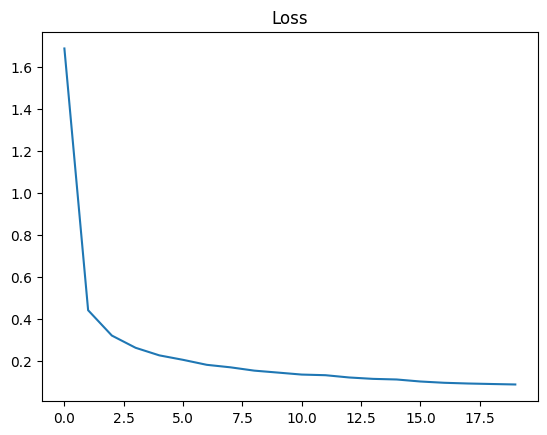

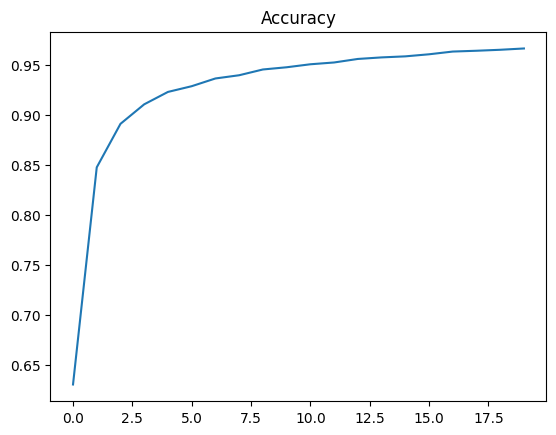

In [41]:
#plot the loss and accuracy
plt.plot(losses)
plt.title("Loss")
plt.show()

plt.plot(accuracy)
plt.title("Accuracy")
plt.show()



In [42]:
test_accuracies = []
all_prediction_logits = []
for batch, (X,y) in tqdm(enumerate((test_loader))):
    optimizer.zero_grad()
    X, y = X,y
    X,y= X.cuda().float(), y.cuda().long()


    prediction_logits, auxiliary,tau = model(X)

    aux_loss = auxiliary_criterion(auxiliary, X)
    loss = aux_loss
    # print("aux_loss", aux_loss.item())
    loss.backward()
    optimizer.step()
    
    prediction_logits, auxiliary,tau = model(X)
    prediction = F.softmax(prediction_logits, dim=1)
    prediction = torch.argmax(prediction, dim=1)
    all_prediction_logits.extend(prediction)
    batch_accuracy = (prediction == y).sum().item() / len(y)
    test_accuracies.append(batch_accuracy)

print(f"Test Accuracy: {np.mean(test_accuracies)}")



Test Accuracy: 0.6081730769230769


In [43]:
test_accuracies

[1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

# Noise Dataset

In [44]:

dataset = df_noise
target_column = "target_10_val"
output_classes = 5
shuffle = True


In [45]:
new_dataset = dataset.drop(columns=["target_5_val", "sigma"])
era = new_dataset.pop("era")
target = new_dataset.pop(target_column)
new_dataset[target_column] = target
new_dataset["era"] = era
new_dataset

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,day_no,target_10_val,era
0,1.0,0.75,1.0,0.5,0.0,1.0,1.0,0.00,0.00,1.00,...,0.50,0.50,0.25,0.25,0.00,75,550,0,4,6
1,1.0,1.00,1.0,1.0,0.0,1.0,1.0,0.75,0.50,0.75,...,0.25,0.25,0.50,0.50,0.50,76,550,0,3,6
2,1.0,1.00,1.0,1.0,0.0,1.0,1.0,0.25,0.00,0.75,...,0.00,0.25,0.25,0.25,0.25,77,550,0,4,6
3,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1.00,0.25,0.00,...,0.00,0.00,0.50,0.50,0.50,78,550,0,1,6
4,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1.00,0.00,0.00,...,0.00,0.00,0.25,0.50,0.50,79,550,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62395,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1.00,0.50,0.75,...,0.50,1.00,0.75,1.00,0.75,135,548,959,0,5
62396,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1.00,0.50,0.75,...,0.25,1.00,0.50,0.50,0.50,136,548,959,0,5
62397,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1.00,1.00,0.25,...,0.00,1.00,0.75,0.75,0.25,137,548,959,0,5
62398,1.0,1.00,1.0,1.0,0.0,1.0,1.0,0.75,1.00,0.50,...,0.50,1.00,0.50,0.50,0.00,138,548,959,0,5


In [46]:
train_dataset = CustomDataset(new_dataset.drop(columns=[target_column,'era','row_num','day','day_no']).values, new_dataset[target_column].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=shuffle)

In [47]:

test_set = df_test_noise
target_column = "target_10_val"
output_classes = 5


In [48]:
test_dataset = CustomDataset(new_test_dataset.drop(columns=[target_column,'era','row_num','day','day_no']).values, new_test_dataset[target_column].values)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [49]:
# train the model on Train data this is not test time training yet
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TTA(input_size=24, classification_output_size=5, auxiliary_output_size=24)
model.cuda()
# classification_criterion = nn.CrossEntropyLoss()
classification_criterion = NoiseAttentionLoss()
auxiliary_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
bagging_percent = 0.9


epochs = 20
losses = []
predictions = []
accuracy = []

for epoch in tqdm(range(epochs)):
    # loop = tqdm(train_loader, leave=True)
    epoch_acc=[]
    epoch_loss=[]
    for batch,(X, y) in enumerate(train_loader):
        X, y = X.cuda().float(), y.cuda().long()
        
        # # mask 5 columns in X
        # mask = torch.randint(0, 27, (5,))
        # X[:, mask] = 0

        optimizer.zero_grad()
        prediction_logits, auxiliary,tau = model(X)
        # print(tau)
        prediction_softmax = F.softmax(prediction_logits, dim=1).to(torch.float64)
        prediction = torch.argmax(prediction_softmax, dim=1)

        loss1 = classification_criterion(prediction_softmax, y,tau)
        # print(prediction_logits)
        loss2 = auxiliary_criterion(auxiliary, X)
        # print(loss1.item(), loss2.item()    )
        accuracy_batch = (prediction == y).sum().item() / len(y)
        epoch_acc.append(accuracy_batch)

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        epoch_loss.append(loss.item())
        predictions.append(prediction)
        # break
        # if batch == bagging_percent * len(train_loader):
        #     break
    accuracy.append(np.mean(epoch_acc))
    losses.append(np.mean(epoch_loss))
    print(f"Epoch {epoch} Loss: {np.mean(epoch_loss)} Accuracy: {np.mean(epoch_acc)}")

    

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss: 4.57133479034846 Accuracy: 0.22193910256410257
Epoch 1 Loss: 3.156054964040257 Accuracy: 0.2474198717948718
Epoch 2 Loss: 3.113331223532327 Accuracy: 0.2925641025641026
Epoch 3 Loss: 3.0860972396597024 Accuracy: 0.31272435897435896
Epoch 4 Loss: 2.941651286694537 Accuracy: 0.3330448717948718
Epoch 5 Loss: 2.1296382300204604 Accuracy: 0.4475480769230769
Epoch 6 Loss: 2.0926889449297925 Accuracy: 0.4584935897435897
Epoch 7 Loss: 2.0701845370788425 Accuracy: 0.46581730769230767
Epoch 8 Loss: 2.051200513124634 Accuracy: 0.47208333333333335
Epoch 9 Loss: 2.0342855507805697 Accuracy: 0.4755128205128205
Epoch 10 Loss: 2.0229122350719746 Accuracy: 0.47907051282051283
Epoch 11 Loss: 1.9150516391963055 Accuracy: 0.4905448717948718
Epoch 12 Loss: 0.9417429961572051 Accuracy: 0.6103205128205128
Epoch 13 Loss: 0.91408217035184 Accuracy: 0.6201121794871794
Epoch 14 Loss: 0.9052585575378956 Accuracy: 0.6220833333333333
Epoch 15 Loss: 0.8952279352990041 Accuracy: 0.627099358974359
Epoch 

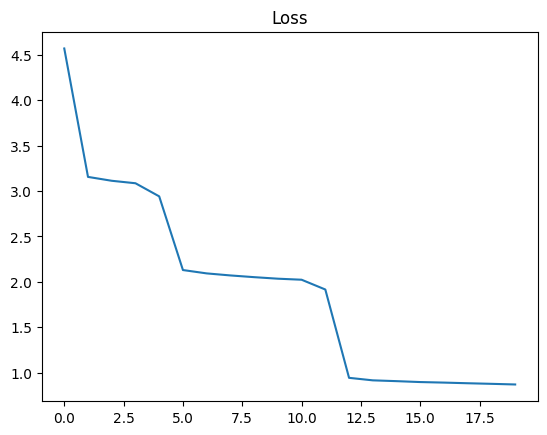

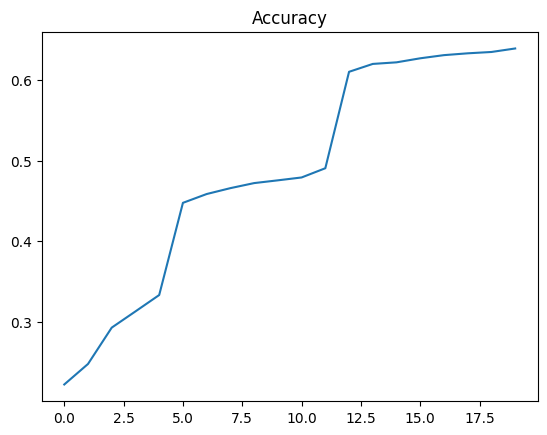

In [50]:
# plot the loss and accuracy
plt.plot(losses)
plt.title("Loss")
plt.show()
plt.plot(accuracy)
plt.title("Accuracy")
plt.show()

In [51]:
# test the model on test data
test_accuracies = []
all_prediction_logits = []

for batch, (X,y) in tqdm(enumerate((test_loader))):
    optimizer.zero_grad()
    X, y = X,y
    X,y= X.cuda().float(), y.cuda().long()
    prediction_logits, auxiliary,tau = model(X)

    aux_loss = auxiliary_criterion(auxiliary, X)
    loss = aux_loss
    # print("aux_loss", aux_loss.item())
    loss.backward()
    optimizer.step()
    
    prediction_logits, auxiliary,tau = model(X)
    prediction = F.softmax(prediction_logits, dim=1)
    prediction = torch.argmax(prediction, dim=1)
    all_prediction_logits.extend(prediction)
    batch_accuracy = (prediction == y).sum().item() / len(y)
    test_accuracies.append(batch_accuracy)
print(f"Test Accuracy: {np.mean(test_accuracies)}")




0it [00:00, ?it/s]

Test Accuracy: 0.6890865384615384
